In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as color
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram_shift, mesh, illumination_beam
from project.algorithms.utils import circ_aperture, normalize
from project.algorithms.reconstruction import epie

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [28]:
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape= (101, 101)   # the size of reconstruction box
r = 0.5
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)
norm = color.Normalize(-np.pi, np.pi)
rainbow = cm.ScalarMappable(norm=norm, cmap='rainbow')
gray = cm.ScalarMappable(cmap='gray')

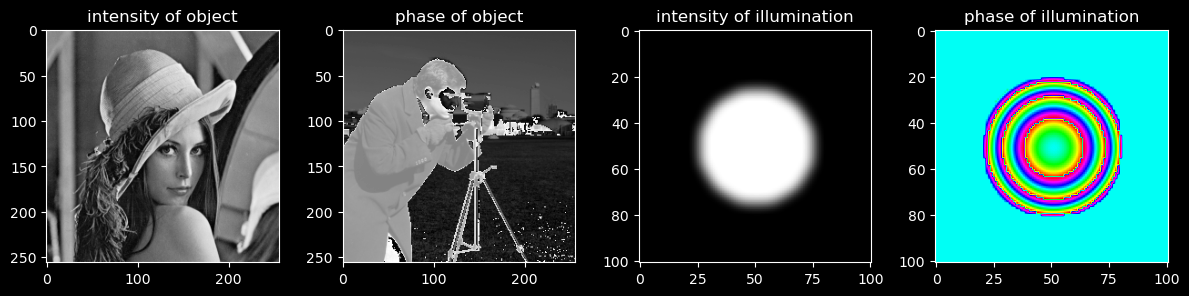

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(obj), cmap='gray')
axes[0].set_title('intensity of object')
# plt.colorbar(gray, ax=axes[0], ticks=[0, 0.5, 1], format='%.1f')
axes[1].imshow(np.angle(obj), cmap='gray')
axes[1].set_title('phase of object')
# plt.colorbar(rainbow, ax=axes[1], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[2].imshow(np.abs(illumination), cmap='gray')
axes[2].set_title('intensity of illumination')
# plt.colorbar(gray, ax=axes[2], ticks=[0, 0.5, 1], format='%.1f')
axes[3].imshow(np.angle(illumination), cmap='hsv')
# plt.colorbar(rainbow, ax=axes[3], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[3].set_title('phase of illumination')
plt.tight_layout()
plt.savefig("ground_truth")

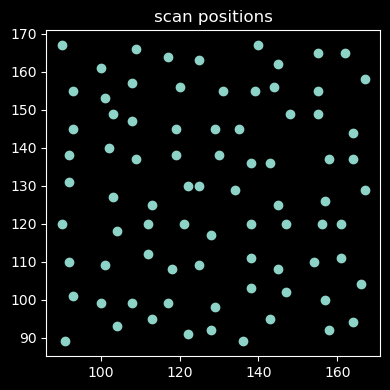

In [41]:
positions = mesh((256, 256), 25, 0.8, 9, error=3)
# positions = np.load('positions.npy')
patterns = []
for position in positions:
    pattern = ptychogram_shift(obj, illumination, position)
    patterns.append(pattern)
plt.figure(figsize=(4, 4))
plt.scatter(*np.transpose(positions))
# plt.scatter(*np.transpose(guess_position1))
plt.title('scan positions')
plt.tight_layout()
# plt.savefig('positions')

In [50]:
guess_probe = circ_aperture(box_shape, radius=0.4).astype('complex')
guess_position = np.array(positions)
recon_obj, rencon_probe, loss = epie(patterns, guess_position, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=300)

In [51]:
print(np.min(loss))

0.10553994245800966


(0.015, 0.6)

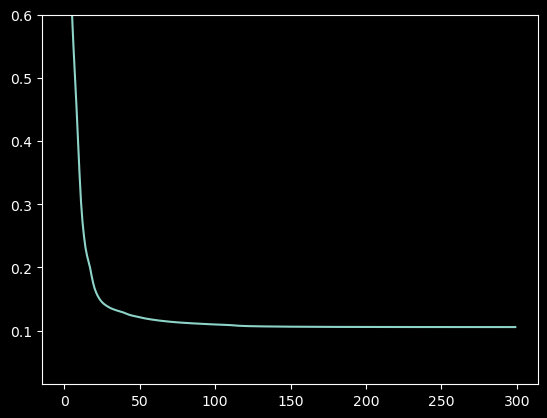

In [52]:
plt.plot(loss)
plt.ylim(0.015, 0.6)

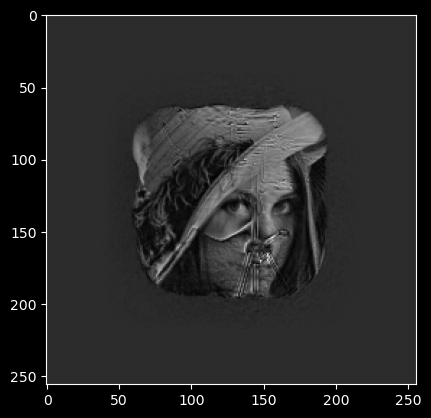

In [53]:
plt.imshow(abs(recon_obj), cmap='gray')

In [23]:
recon_obj1, rencon_probe1, loss1 = epie(patterns, guess_position, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=200, random_update=True)

In [38]:
recon_obj1, rencon_probe1, loss1 = [recon_obj], [rencon_probe], [loss]
for e in range(1,4):
    guess_positions1 = np.array(positions)
    perror = np.random.randint(-e, e+1, size=guess_positions1.shape)
    guess_positions1 += perror
    o, p, l = epie(patterns, guess_positions1, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=200,random_update=True)
    recon_obj1.append(o)
    rencon_probe1.append(p)
    loss1.append(l)

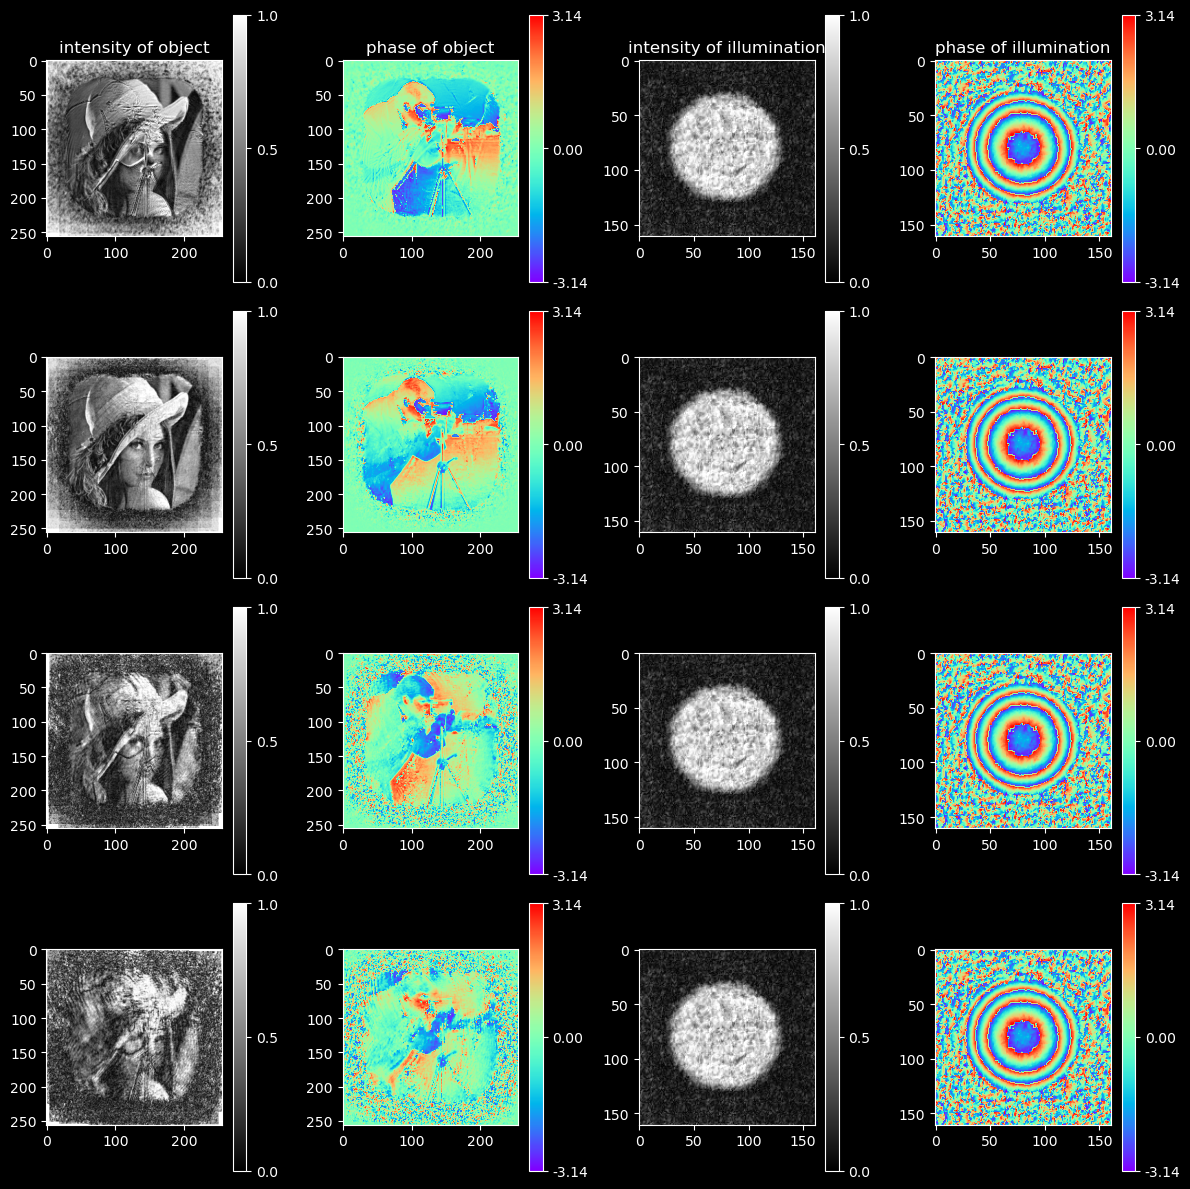

In [41]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    axes[i, 0].imshow(np.abs(recon_obj1[i]), cmap='gray')
    plt.colorbar(gray, ax=axes[i, 0], ticks=[0, 0.5, 1], format='%.1f')
    axes[i, 1].imshow(np.angle(recon_obj1[i]), cmap='rainbow', vmin=-np.pi, vmax=np.pi)
    plt.colorbar(rainbow, ax=axes[i, 1], ticks=[-np.pi, 0, np.pi], format='%.2f')
    axes[i, 2].imshow(np.abs(rencon_probe1[i]), cmap='gray')
    plt.colorbar(gray, ax=axes[i, 2], ticks=[0, 0.5, 1], format='%.1f')
    axes[i, 3].imshow(np.angle(rencon_probe1[i]), cmap='rainbow')
    plt.colorbar(rainbow, ax=axes[i, 3], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[0, 0].set_title('intensity of object')
axes[0, 1].set_title('phase of object')
axes[0, 2].set_title('intensity of illumination')
axes[0, 3].set_title('phase of illumination')
plt.tight_layout()
plt.savefig('ePIE result')

In [15]:
# np.save('positions.npy', positions)
# plt.savefig('positions')

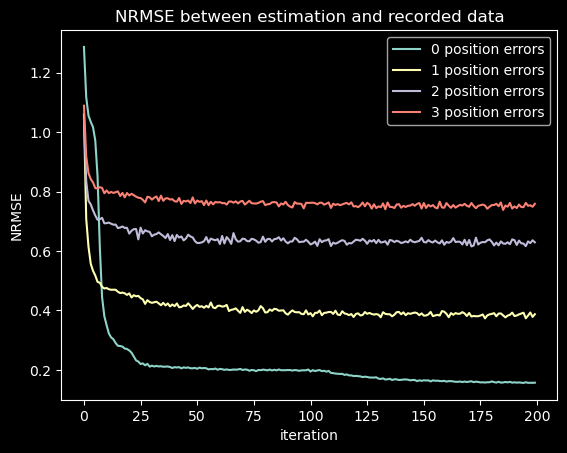

In [40]:
for i in range(4):
    plt.plot(loss1[i], label='%i position errors'%i)
plt.title('NRMSE between estimation and recorded data')
plt.xlabel('iteration')
plt.ylabel('NRMSE')
# plt.ylim(0.003,1)
plt.legend()
plt.savefig('loss')